# Setup

In [1]:
import os
import pandas as pd
pd.set_option("display.max_colwidth", None)

os.environ["AZURE_OPENAI_ENDPOINT"] = "https://dalle3-swo.openai.azure.com/"
os.environ["AZURE_OPENAI_API_KEY"] = "e51119f8d8774069a6594d92ccf7a70d"

In [2]:
from langchain_community.utilities import GoogleSearchAPIWrapper
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings, OpenAIEmbeddings
from langchain_core.output_parsers import BaseOutputParser
from typing import List, Optional
import re
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import chain
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo",
    temperature=0
) 

gpt_35_turbo_16k = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo-16k",
    temperature=0
) 

smart_llm = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-4",
    temperature=0
) 
gpt_35_turbo_instruct = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo-instruct",
    temperature=0
) 
# Embedding

embeddings_3_large = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-large",
    openai_api_version="2024-02-15-preview",
    max_retries=5,
    retry_min_seconds=120,
    retry_max_seconds=500,
    show_progress_bar=True,
)

# Test questions

In [3]:
question_lists = [
    # Test again with True answer
    "How do students have lunch at BUV if they have to study a full day?",
    "Where do I get student’s scholarship maintenance criteria?",
    # Test for false answer
    "I want to get a copy of the scholarship maintenance form",
    "How can I have the weekly menus updated?",
    "What is the link to the website for topping up?",
    "What should I do if I lose the Student ID Card?",
    "When is the bus schedule for the weekday sent out?",
    "Can I have the room list to book for self-studying?",
    "How can I contact the Transportation Team?",
    "What is the email address of the Transportation Team?"
]

# Implementation

## Preprocessing BUV q&a file

In [4]:
su_qna = pd.read_excel('../../data/qna_update_data/process_data/su_jul24_qna.xlsx')

In [5]:
from langchain.docstore.document import Document

su_qna_docs = []
for row in su_qna.itertuples(index=True, name='Pandas'):
    document = Document(page_content=row.page_content, 
                        metadata = {"file_name": row.file_name, 
                                    "page": row.page})
    su_qna_docs.append(document)

In [6]:
len(su_qna_docs)

83

In [7]:
print(su_qna_docs[20].page_content)

How can I receive bus schedule? / Làm thế nào để tôi có thể nhận được lịch xe bus.

Answer / Câu trả lời:

The bus schedules are updated weekly to attending students of current semester through their BUV email. The weekday schedules will be sent to students on Friday weekly with the updated schedule for the week after. The weekend schedules for those attending classes or events only will be sent to relevant people on Tuesday of that week. Bus usage guidelines will be sent to students via their BUV student email before the first day of the semester or whenever there is an adjustment.

Besides, you can join our bus communities via QR codes below to be updated on daily information of each route. We encourage students to contact the Transportation team via hotline number 0704 068 386 and email transportation@buv.edu.vn for more detailed information.

Lịch xe buýt BUV được cập nhật hàng tuần cho các sinh viên có thời khóa biểu và lịch trình trong kỳ học hiện tại qua địa chỉ email BUV cá nhâ

## Preprocessing student handbook file

In [8]:
student_handbook_df = pd.read_excel('../../data/qna_update_data/process_data/student_handbook_23_24.xlsx')

In [9]:
from langchain.docstore.document import Document

student_handbook_docs = []
for row in student_handbook_df.itertuples(index=True, name='Pandas'):
    document = Document(page_content=row.page_content, 
                        metadata = {"file_name": row.file_name, 
                                    "page": row.page})
    student_handbook_docs.append(document)

In [10]:
len(student_handbook_docs)

62

In [11]:
print(student_handbook_docs[0].metadata)

{'file_name': 'Student Handbook 2023-2024.pdf', 'page': 4}


In [12]:
print(student_handbook_docs[0].page_content)

# Introduction to the Student Handbook  
Welcome to British University Vietnam. During your course of study, we aim to not only provide you with an excellent learning experience, but also to help you develop the transferable skills that will prepare you for life after university. This means that as a BUV graduate, you will be fully equipped to succeed in both the workplace and in your personal life. Moreover, you will have all the tools necessary to take on any leadership positions in the future.  
This handbook provides you with essential information to fully utilize your time at British University Vietnam. It is vital to your success and the enjoyment of your experience here that you read this handbook carefully. If there is any unclear information in this handbook, please kindly reach out to any of our university staff, we are happy to assist you with any questions you might have. Please note this version is for July 2024 semester.  
Remember that as a student at British University 

## Process psg file

In [13]:
psg_handbook_df = pd.read_excel('../../data/qna_update_data/process_data/psg_programme_handbook_23_24.xlsx')

In [14]:
from langchain.docstore.document import Document

psg_handbook_docs = []
for row in psg_handbook_df.itertuples(index=True, name='Pandas'):
    document = Document(page_content=row.page_content, 
                        metadata = {"file_name": row.file_name, 
                                    "page": row.page})
    psg_handbook_docs.append(document)

In [15]:
len(psg_handbook_docs)

31

In [16]:
print(psg_handbook_docs[0].metadata)

{'file_name': 'PSG Programme Handbook.pdf', 'page': 3}


In [17]:
print(psg_handbook_docs[28].page_content)

### If I am not a student-led project leader, how can I earn points in the University and Community Engagement quadrant?  
Keep in mind that student-led projects do not need to be fancy, complicated or too far-reaching. Simply initiating an idea or attempting to run a campaign to raise awareness on social issues, e.g., cyber-bullying or recycling, can already be a meaningful project for the students. BUV fully supports students to try new things and experience growth in the most active way possible.  
Members’ contributions will be recognised by the Core Organising Team (Project Leader, or Heads of Functions) during an evaluation process after each project and event. This evaluation process ensures that the members/coordinators/officers contribute and learn efficiently during the event/project. After the evaluation, members/coordinators/officers can receive from 20 to 80 points depending on the level of contribution assessed by their leaders.


## Combine three docs

In [18]:
final_docs =  su_qna_docs + student_handbook_docs + psg_handbook_docs

In [19]:
len(final_docs)

176

In [20]:
print(final_docs[-10].page_content)

### What happens if I don’t get PSG points for at least one out of 4 quadrants (e.g. no points for Social, Cultural and Emotional Development) even if I meet the other 2 criteria?  
You will not be eligible for a PSG certificate and transcript if you fail to participate in activities under all four quadrants: Work and Career Readiness; University and Community Engagement; Social, Cultural and Emotional Development; Academic Excellence.  
The goal of participation in all four quadrants of activities is to diversify students’ experiences and help students become more well-rounded in a wide range of personal, career, social, and academic aspects. For the most beneficial and meaningful PSG experience, students are expected to demonstrate active participation through both quantity (earning the minimum required points) and quality (engaging in a diverse range of activities). You can choose to focus on one quadrant or more depending on your interests and schedules, but it is important that yo

## Count token
Per parent document

In [24]:
list_page_content = [doc.page_content for doc in final_docs]

In [25]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


num_tokens = list(map(num_tokens_from_string, list_page_content))

<Axes: ylabel='Frequency'>

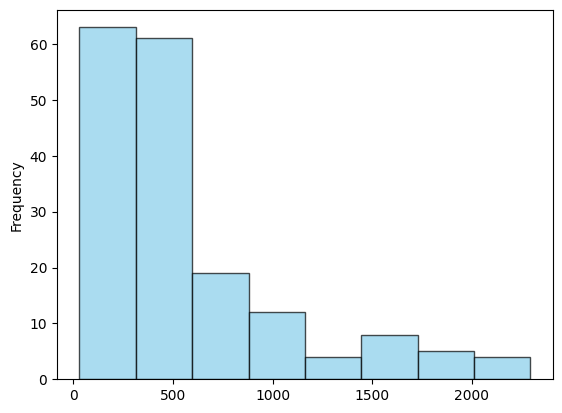

In [26]:
import pandas as pd
# Create a DataFrame from the list
df = pd.DataFrame(num_tokens, columns=['Value'])

# Plot the distribution
df['Value'].plot(kind='hist', bins=8, color='skyblue', edgecolor='black', alpha=0.7)
# df['Value'].plot(kind='kde', color='red')


In [27]:
df.describe()

,Value
count,176.000000
mean,569.426136
std,500.831669
min,31.000000
25%,235.000000
50%,416.500000
75%,663.750000
max,2294.000000


## Retrievers

### Parent document retrievers

In [22]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore, LocalFileStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage._lc_store import create_kv_docstore


# This text splitter is used to create the child documents
child_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400, chunk_overlap=100, add_start_index=True
)
# The vectorstore to use to index the child chunks
vectorstore_chunk_zie_400 = Chroma(
    persist_directory="./chroma_db/su_embedding_400_large_with_source", embedding_function=embeddings_3_large
)
# The storage layer for the parent documents
# store = InMemoryStore()
fs = LocalFileStore("./parent_document_store/su_embedding_large_with_source")
store = create_kv_docstore(fs)
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore_chunk_zie_400,
    docstore=store,
    child_splitter=child_splitter,
    search_kwargs={"k": 2},
)

Because the document is too long which cause embedding getting 503 error --> split the documents and add seperately to reduce the length (limit rate)

In [23]:
# parent_document_retriever.add_documents(final_docs, ids=None)
parent_document_retriever.add_documents(final_docs[:88], ids=None)

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
parent_document_retriever.add_documents(final_docs[88:], ids=None)

  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
len(list(store.yield_keys()))

176

In [106]:
a = vectorstore_chunk_zie_400.similarity_search("How can I be recognised as completing a professional experience option or alternative?")

In [108]:
print(a[1].page_content)

Internship Recognition: After an internship or similar professional experience, you will need to submit a valid Internship Evaluation Form (IEF), approved by the Head of Student Engagement, to get PSG points. The Internship Completion Certificate which is not compulsory for your PSG Transcript will be only issued upon your request. The specific requirements of a valid IEF and how to request a


In [154]:
b = parent_document_retriever.invoke("I'm Thuy from cohort 2110IBM and I'm planning to apply for a Master's Degree in the future. It is clear that a 'personal statement' is the most important part of the application process, however, I didn't have much experience on writing a personal statement. Therefore, are there any lectures or staff at BUV that can help me to with this issues?")

In [157]:
print(b[0].page_content)

How can students improve their English if students/parents would like to enhance their English skills? / Nhà trường có thể giúp gì nếu phụ huynh và sinh viên có nhu cầu cải thiện trình độ Tiếng Anh của sinh viên?

Answer / Câu trả lời:

Improving student’s English skills is always one of the top priorities at BUV as our results show that students with higher level of English tend to achieve better academic results than those having lower English ability. We have a very dedicated English Department which provides various support to students who are willing to improve their English skills. Students are highly recommended to book a meeting with a member of this department for assistance with any language-related inquiries. Alternatively, they can contact James McMillan – Deputy Programme Leader of English at james.mcmillan@buv.edu.vn for the advice.

In addition, BUV also organizes weekly Academic English Master classes on Canvas to enhance student’s ability to use English effectively in 

#### Reload parent document retriever

In fact, the ParentDocumentRetriever could be replaced by a MultiVectorRetriever instance since the difference between the two is the add_documents method that the ParentDocumentRetriever has.

Refer to here: https://github.com/langchain-ai/langchain/issues/9345

In [96]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore, LocalFileStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage._lc_store import create_kv_docstore
from langchain.retrievers import MultiVectorRetriever



# The vectorstore to use to index the child chunks
vectorstore_chunk_zie_400 = Chroma(
    persist_directory="./chroma_db/buv_and_student_handbook_400", embedding_function=embeddings
)
# The storage layer for the parent documents
# store = InMemoryStore()
fs = LocalFileStore("./parent_document_store/buv_and_student_handbook")
store = create_kv_docstore(fs)
parent_document_retriever = MultiVectorRetriever(
    vectorstore=vectorstore_chunk_zie_400,
    docstore=store,
    search_kwargs={"k": 3},
)

In [95]:
question_lists

['I want to get a copy of the scholarship maintenance form',
 'When does the Student Hub Student Hub & Food Court open?',
 'How can I have the weekly menus updated?',
 'What is the link to the website for topping up?',
 'What should I do if I lose the Student ID Card?',
 'Can I have the room list to book for self-studying?',
 'Can I choose the room to book for self-studying?',
 'When is the bus schedule for the weekday sent out?',
 'Can first year students go for internships?',
 'What should I do if I come across difficulties during my internship?',
 'Which department should I ask for help if I have some issues during the internship?',
 'Can I get the Certificate of Internship Completion?',
 'How many industrial partners are in the career network at BUV?',
 'What is the progression condition at BUV?',
 'what would happen if student fails the resit(s)?',
 'What will happen if the External Examination Board decides for students to retake a module/re-study?',
 'Do I have my result this se

In [97]:
a = vectorstore_chunk_zie_400.similarity_search("What happens if I submit the assignment late?")

In [100]:
print(a[2].page_content)

pick up invaluable work skills, lay the foundation of their professional network, and get a foot in the career door. The internship may benefit students tremendously, still, it is important that students remain aware of their rights and does not let anyone take advantage of them. The Career Services & Industry Relations Team are always available for advice if students feel unsure anytime.


In [62]:
b = parent_document_retriever.invoke("I'm Thuy from cohort 2110IBM and I'm planning to apply for a Master's Degree in the future. It is clear that a 'personal statement' is the most important part of the application process, however, I didn't have much experience on writing a personal statement. Therefore, are there any lectures or staff at BUV that can help me to with this issues?")

In [65]:
print(b[0].page_content)

How can students improve their English if students/parents would like to enhance their English skills? / Nhà trường có thể giúp gì nếu phụ huynh và sinh viên có nhu cầu cải thiện trình độ Tiếng Anh của sinh viên?

Answer / Câu trả lời:

Improving student’s English skills is always one of the top priorities at BUV as our results show that students with higher level of English tend to achieve better academic results than those having lower English ability. We have a very dedicated English Department which provides various support to students who are willing to improve their English skills. Students are highly recommended to book a meeting with a member of this department for assistance with any language-related inquiries. Alternatively, they can contact James McMillan – Deputy Programme Leader of English at james.mcmillan@buv.edu.vn for the advice.

In addition, BUV also organizes weekly Academic English Master classes on Canvas to enhance student’s ability to use English effectively in 

## Create chain

In [178]:
template_2 = """
As an AI assistant specializing in student support, your task is to provide concise and comprehensive answers to specific questions based on the provided context. 

Instructions:
1. Begin by reading the context carefully.
2. Answer the question based on the information given in the context.
3. If the answer is not available in the context, admit that you don't know the answer. Do not fabricate responses.
4. If the question pertains to a specific term (like PDP), form (like Personal statement), or template, and the context does NOT EXPLICITLY mention these, admit your lack of knowledge and suggest the student to reach out to the Student Information Office. Do not make up responses.
5. Keep your answer as succinct as possible, but ensure it includes all relevant information from the context. For examples: 
    - if students ask about a department or services, you should answer not only department name or serivec name, but also service link and department contact such as email, phone, ... if those information have in the context. 
    - if context does not have specific answer, but contain reference information such as reference link, reference contact point, support contact point and so on. Then you should show it up.
    - if context contains advices for specific student's action, you should show it up.
6. Conclude your answer with "Thanks for asking!" to maintain a friendly interaction.

### 

Context:
{context}

Question: 
{question}

Your Informative Answer:"""

In [180]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs_vectorstore_retriever(docs, num_parent_docs=2):
    return "\n\n".join(doc.page_content for doc in docs[:num_parent_docs])

def format_docs_parent_retriever(docs, num_parent_docs=2):
    return "\n\n".join(doc.page_content for doc in docs[:num_parent_docs])

template = """
As an AI assistant specializing in student support, your task is to provide concise and comprehensive answers to specific questions based on the provided context. 

Instructions:
1. Begin by reading the context carefully.
2. Answer the question based on the information given in the context.
3. If the answer is not available in the context, admit that you don't know the answer. Do not fabricate responses.
4. Keep your answer as succinct as possible, but ensure it includes all relevant information from the context. For examples: 
    - if students ask about a department or services, you should answer not only department name or serivec name, but also service link and department contact such as email, phone, ... if those information have in the context. 
    - if context does not have specific answer, but contain reference information such as reference link, reference contact point, support contact point and so on. Then you should show it up.
    - if context contains advices for specific student's action, you should show it up.
5. Conclude your answer with "Thanks for asking!" to maintain a friendly interaction.

### 

Context:
{context}

Question: 
{question}

Your Informative Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

from operator import itemgetter

rag_chain_with_parent_retriever = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | custom_rag_prompt
    | gpt_35_turbo_16k
    | StrOutputParser()
)

rag_chain_with_parent_retriever_with_template_2 = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | PromptTemplate.from_template(template_2)
    | gpt_35_turbo_16k
    | StrOutputParser()
)

smart_rag_chain_with_parent_retriever_with_template_2 = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | PromptTemplate.from_template(template_2)
    | smart_llm
    | StrOutputParser()
)



In [163]:
print(rag_chain_with_parent_retriever.invoke({'question':"I'm Thuy from cohort 2110IBM and I'm planning to apply for a Master's Degree in the future. It is clear that a 'personal statement' is the most important part of the application process, however, I didn't have much experience on writing a personal statement. Therefore, are there any lectures or staff at BUV that can help me to with this issues?"}))

Yes, BUV has a dedicated English Department that provides support to students who need assistance with language-related inquiries, including writing personal statements. I recommend booking a meeting with a member of the English Department for guidance on writing a personal statement. Alternatively, you can contact James McMillan, the Deputy Programme Leader of English, at james.mcmillan@buv.edu.vn for advice on this matter. They will be able to provide you with helpful tips and guidance to improve your personal statement writing skills. Thanks for asking!


In [181]:
print(rag_chain_with_parent_retriever_with_template_2.invoke({'question':"What will happen to my PDP activity records and transcripts when I am transferred to the new PSG Programme?"}))

Your PDP activity records and transcripts will be transferred to the new PSG Programme. The PSG Programme aims to build upon and enhance the Personal Development Planning (PDP) activities that you have already completed. Your previous PDP activity records and transcripts will be considered as part of your overall PSG journey and will contribute to your PSG points and achievements. It is important to note that the PSG Programme offers a wider range of activities and opportunities for personal and social growth. For more information and details about the PSG Programme, you can refer to the Personal and Social Growth (PSG) Programme course on your Canvas account. Thanks for asking!


In [182]:
print(smart_rag_chain_with_parent_retriever_with_template_2.invoke({'question':"What will happen to my PDP activity records and transcripts when I am transferred to the new PSG Programme?"}))

The context does not provide specific information on what will happen to your PDP activity records and transcripts when you are transferred to the new PSG Programme. I recommend reaching out to the Student Information Office for further assistance on this matter. Thanks for asking!


## Add sources

In [19]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs_with_sources(docs: List[Document]) -> str:
    formatted = []
    for i, doc in enumerate(docs[:2]):
        doc_str = f"""\
        Source Name: {doc.metadata['file_name']} - {doc.metadata['page']}
        Information: {doc.page_content}
        """
        formatted.append(doc_str)
    return "\n\n".join(formatted)

template_with_sources = """
As an AI assistant specializing in student support, your task is to provide concise and comprehensive answers to specific questions based on the provided context. 
The context is a list of sources. Each source includes source name and information.
You MUST follow instruction deliminated by ###.

###
Instructions:

1. Begin by reading the context carefully.
2. Answer the question based on the information given in the context.
3. If the answer is not available in the context, admit that you don't know the answer. Do not fabricate responses.
4. Keep your answer as succinct as possible, but ensure it includes all relevant information from the context. For examples: 
    - if students ask about a department or services, you should answer not only department name or serivec name, but also service link and department contact such as email, phone, ... if those information have in the context. 
    - if context does not have specific answer, but contain reference information such as reference link, reference contact point, support contact point and so on. Then you should show it up.
    - if context contains advices for specific student's action, you should show it up.
5. Always include the source name from the context for each fact you use in the response in the following format: 
```
response here
Sources:
- Source name 1
- Source name 2
....
- Source name n
```
### 

Context:
{context}

Question: 
{question}

Your Informative Answer and Citations:"""
from operator import itemgetter

rag_chain_with_parent_retriever_with_sources = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_with_sources, "question": itemgetter("question")}
    | PromptTemplate.from_template(template_with_sources)
    | gpt_35_turbo_16k
    | StrOutputParser()
)

In [21]:
print(rag_chain_with_parent_retriever_with_sources.invoke({"question":"I'm on a company trip next week that I can not go to the campus. Can you provide me with the absence form?"}))

To request an absence from classes due to a company trip, you will need to submit an absence form along with the necessary evidence. The process for submitting an absence request is as follows:

1. For plannable leaves, such as a company trip, you should submit the form and evidence at least one day in advance of the absent date.

2. The absence form and evidence must be handed in at the Student Information Office counter on the 2nd floor of the main building or via studentservice@buv.edu.vn.

Please note that the absence application form values are only for requesting absence from classes and cannot be replaced with any other documents.

Sources:
- Student Handbook - 18-21


# Testing

In [22]:
question_lists

['How do students have lunch at BUV if they have to study a full day?',
 'Where do I get student’s scholarship maintenance criteria?',
 'I want to get a copy of the scholarship maintenance form',
 'How can I have the weekly menus updated?',
 'What is the link to the website for topping up?',
 'What should I do if I lose the Student ID Card?',
 'When is the bus schedule for the weekday sent out?',
 'Can I have the room list to book for self-studying?',
 'How can I contact the Transportation Team?',
 'What is the email address of the Transportation Team?']

In [51]:
bot_answers_with_vectorstore_as_retriever =  [rag_chain_with_vectorstore_retriever.invoke({'question':q}) for q in question_lists]

In [23]:
bot_answers_with_parent_document_as_retriever =  [rag_chain_with_parent_retriever.invoke({'question':q}) for q in question_lists[-5:]]

In [24]:
import pandas as pd
answer_df = pd.DataFrame({
    "Question": question_lists[-5:],
    # "bot_answers_with_vectorstore_as_retriever": bot_answers_with_vectorstore_as_retriever,
    "bot_answers_with_parent_document_as_retriever": bot_answers_with_parent_document_as_retriever
})

In [ ]:
print(answer_df.to_markdown())

|    | Question                                              | bot_answers_with_parent_document_as_retriever                                                                                                                                                                                                                                                           |
|---:|:------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | What should I do if I lose the Student ID Card?       | If you lose your Student ID card, please inform the Student Information Office for a reissue. Your lost card will be temporarily locked, and the balance will be transferred to the new card, with the password reset to "123456". Your convenience and security are our priorities. Thanks for asking! |
|  1 | When is the bus schedule for the weekday sent out?    | The bus schedule for the weekday is sent out to students on Friday weekly. Thanks for asking!                                                                                                                                                                                                           |
|  2 | Can I have the room list to book for self-studying?   | I'm sorry, but I don't have access to the specific room list for self-studying. You can contact the Student Information Office directly for more information on available rooms for self-study. Thanks for asking!                                                                                      |
|  3 | How can I contact the Transportation Team?            | You can contact the Transportation Team via the hotline at 0704 068 386 or email at transportation@buv.edu.vn. Thanks for asking!                                                                                                                                                                       |
|  4 | What is the email address of the Transportation Team? | The email address of the Transportation Team is transportation@buv.edu.vn. Thanks for asking!                                                                                                                                                                                                           |
